# Run inference on pre-trained model:

In [1]:
import matplotlib.pyplot as plt

import torch

/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torch_geometric/typing.py:18: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: dlopen(/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/libpyg.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <B5FD9895-F13C-386E-85C3-E2998159857E> /Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/libpyg.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torch/lib/libc10.dylib
  warnings.warn(f"An issue occurred while imp

In [2]:
from grace.io.image_dataset import ImageGraphDataset
from grace.models.feature_extractor import FeatureExtractor
from grace.evaluation.visualisation import plot_simple_graph
from grace.evaluation.inference import GraphLabelPredictor


/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <6A7076EE-85BD-37A7-BC35-1D4867F2B3D3> /Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Read some real grace-annotated data:

In [3]:
extractor_filename = "/Users/kulicna/Desktop/classifier/extractor/resnet152.pt"
pre_trained_resnet = torch.load(extractor_filename)
feature_extractor = FeatureExtractor(model=pre_trained_resnet)


In [4]:
# grace_path = "/Users/kulicna/Desktop/dataset/shape_stars/train"
grace_path = "/Users/kulicna/Desktop/dataset/shape_stars/infer"
dataset = ImageGraphDataset(
    image_dir=grace_path, 
    grace_dir=grace_path, 
    transform=feature_extractor,
    keep_node_unknown_labels=False, 
    keep_edge_unknown_labels=False, 
    
)

In [5]:
# image, graph_data = dataset[1]
image, graph_data = dataset[0]

G = graph_data["graph"]
image = image.numpy()
annot = graph_data["annotation"]
G.number_of_nodes(), G.number_of_edges(), annot.shape, image.shape 

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.
/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(189, 552, (3724, 3724), (3724, 3724))

### Visualise the data:

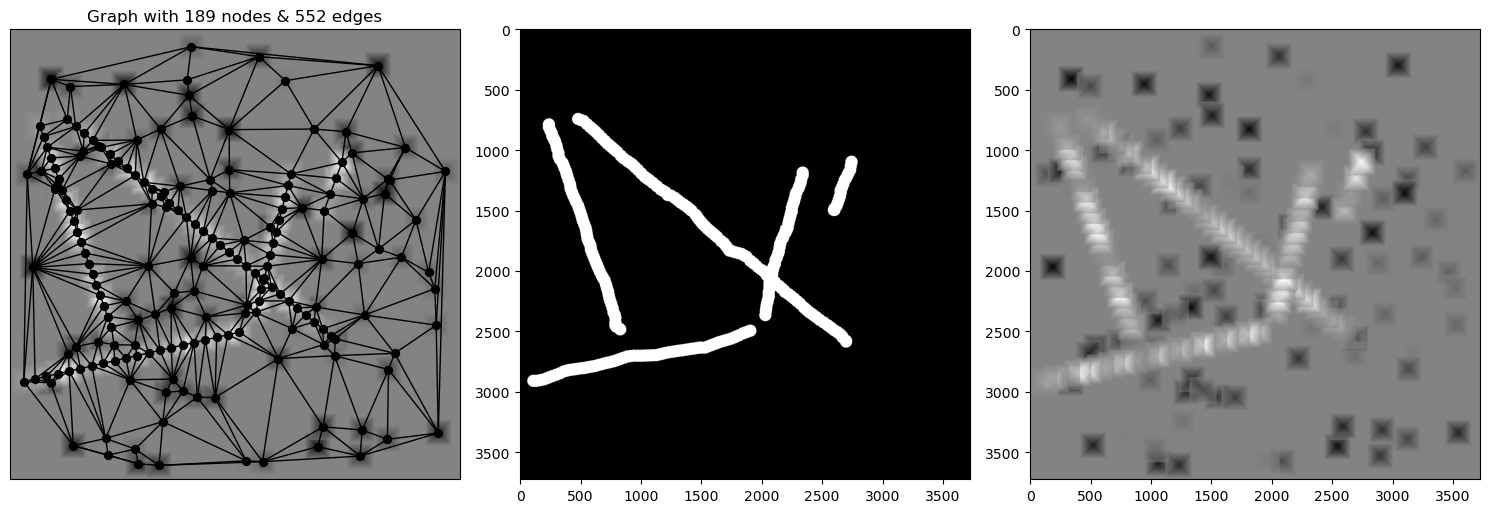

In [6]:
shape = 5
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(shape*3, shape*1))

plot_simple_graph(G, title=f"Graph with {G.number_of_nodes()} nodes & {G.number_of_edges()} edges", ax=axes[0])
axes[0].imshow(image, cmap="binary_r")
axes[1].imshow(annot, cmap="binary_r")
axes[2].imshow(image, cmap="binary_r")

plt.tight_layout()
plt.show()

### Nominate a pre-trained GCN model:

In [12]:
# classifier_filename = "/Users/kulicna/Desktop/classifier/runs/2023-09-07_17-07-08/classifier.pt"
# classifier_filename = "/Users/kulicna/Desktop/classifier/runs/2023-09-07_17-15-47/classifier.pt"
classifier_filename = "/Users/kulicna/Desktop/classifier/runs/2023-09-07_17-30-51/classifier.pt"  # best Linear classifier
# classifier_filename = "/Users/kulicna/Desktop/classifier/runs/2023-09-08_15-11-58/classifier.pt"  # bad GCN + Linear classifier

pre_trained_gcn = torch.load(classifier_filename)
pre_trained_gcn.eval()


GCN(
  (node_classifier): Linear(in_features=2048, out_features=2, bias=True)
  (edge_classifier): Linear(in_features=4096, out_features=2, bias=True)
)

### Features are now automatically appended to the image - predict:

Predicting for the entire graph: 100%|██████████| 1/1 [00:00<00:00, 197.52it/s]


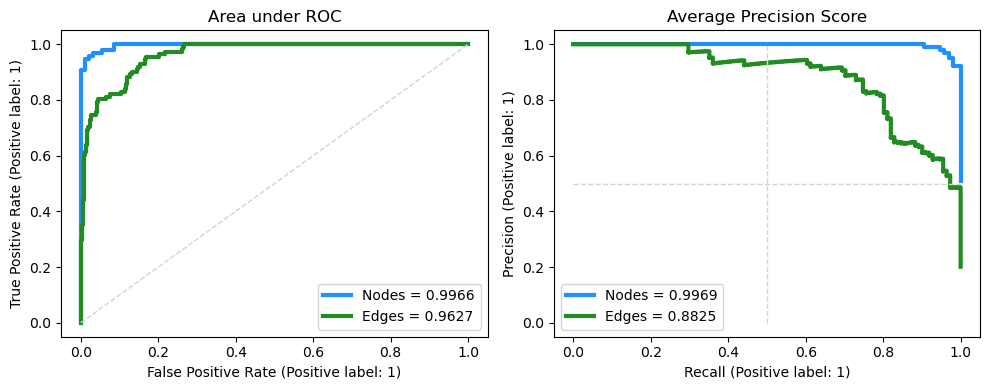

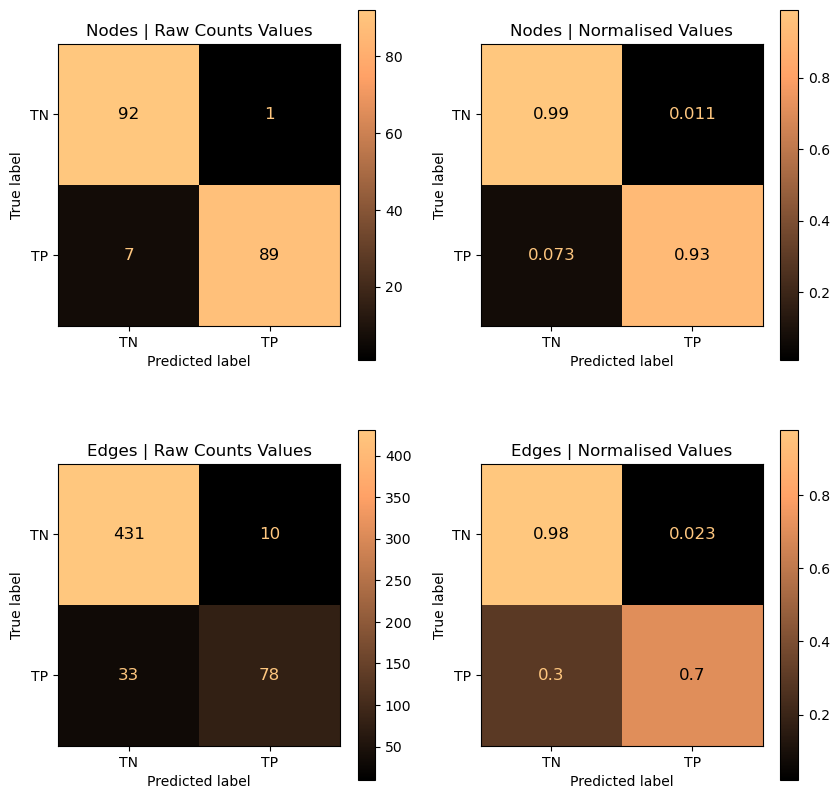

(0.9576719576719577, 0.9221014492753623)

In [13]:
predictor = GraphLabelPredictor(pre_trained_gcn)
predictor.set_node_and_edge_probabilities(G)
node_acc, edge_acc = predictor.visualise_performance(G)
node_acc, edge_acc

##### Done!